In [1]:
%load_ext tensorboard
import os
import random
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import ImageOps
from IPython.display import display
from tensorflow import keras
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, Conv2D, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [2]:
echonet_dir = Path('../Echonet/')
# original_train_dir = echonet_dir / 'Images' / 'Train' / 'EDV' / 'Originals2'
original_train_dir_all = echonet_dir / 'Images' / 'Train' / 'AllOriginals'
# original_val_dir = echonet_dir / 'Images' / 'Val' / 'EDV' / 'Originals2'
original_val_dir_all = echonet_dir / 'Images' / 'Val' / 'AllOriginals'
# mask_train_dir = echonet_dir / 'Images' / 'Train' / 'EDV' / 'Masks'
mask_train_dir_all = echonet_dir / 'Images' / 'Train' / 'AllMasks'
# mask_val_dir = echonet_dir / 'Images' / 'Val' / 'EDV' / 'Masks'
mask_val_dir_all = echonet_dir / 'Images' / 'Val' / 'AllMasks'
overlay_dir = echonet_dir / 'Images' / 'Overlays'

IMG_SIZE = (112, 112)
num_classes = 2
BATCH_SIZE = 64


input_train_original_paths = sorted(
    [
        os.path.join(original_train_dir_all, fname)
        for fname in os.listdir(original_train_dir_all)
        if fname.endswith('.png')
    ]
)

input_train_mask_paths = sorted(
    [
        os.path.join(mask_train_dir_all, fname)
        for fname in os.listdir(mask_train_dir_all)
        if fname.endswith('.png') and not fname.startswith('.')
    ]
)

val_original_paths = sorted(
    [
        os.path.join(original_val_dir_all, fname)
        for fname in os.listdir(original_val_dir_all)
        if fname.endswith('.png')
    ]
)

val_mask_paths = sorted(
    [
        os.path.join(mask_val_dir_all, fname)
        for fname in os.listdir(mask_val_dir_all)
        if fname.endswith('.png') and not fname.startswith('.')
    ]
)

overlay_image_paths = sorted(
    [
        os.path.join(overlay_dir, fname)
        for fname in os.listdir(overlay_dir)
        if fname.endswith('.png') and not fname.startswith('.')
    ]
)


In [3]:
class EchoGen(keras.utils.Sequence):

    def __init__(self, original_paths, mask_paths, batch_size, img_size):
        self.original_paths = original_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return len(self.mask_paths) // self.batch_size

    def on_epoch_end(self):
        random.Random(1337).shuffle(self.original_paths)
        random.Random(1337).shuffle(self.mask_paths)
        #display_pred(example, val_preds)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_original_paths = self.original_paths[i: i + self.batch_size]
        batch_mask_paths = self.mask_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_original_paths):
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255
            img = img.astype(np.float32)
            x[j] = img
            # plt.imshow(img)
            # plt.show()
            # print(img)

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='float32')
        for j, path in enumerate(batch_mask_paths):
            _img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            _img = cv2.resize(_img, IMG_SIZE)
            _img[_img > 0] = 255
            _img = _img / 255
            _img = _img.astype(np.int32)
            _img = np.expand_dims(_img, 2)
            y[j] = _img
            # plt.imshow(_img)
            # plt.show()
            # print(_img)

        return x, y

In [4]:
def build_unet():
    """
    Function to build a Unet based neural network.
    Implements Keras API layers
    Uses pretrained encoder MobileNetV2 trained on ImageNet weights.
    :return: Keras.Model object
    """

    inputs = Input((112, 112, 3), name='input_image')

    # Pretrained encoder block
    base_encoder = keras.applications.MobileNetV2(input_tensor=inputs,
                                                   weights='imagenet',
                                                   include_top=False,
                                                   alpha=1.0)
    base_encoder.summary()
    skip_names = ['input_image',
                  'block_1_expand_relu',   # 56x56
                  'block_3_expand_relu',   # 28x28
                  'block_6_expand_relu']   # 14x14


    encoder_output = base_encoder.get_layer('block_13_expand_relu').output # 7x7

    filters = [64, 128, 256, 512]
    x = encoder_output

    for i in range(1, len(filters)+1, 1):
        x_skip = base_encoder.get_layer(skip_names[-i]).output
        x = UpSampling2D((2,2))(x)
        x = Concatenate()([x, x, x_skip])

        x = Conv2D(filters[-i], (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters[-i], (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = Conv2D(1, (1,1), padding='same')(x)
    x = Activation('sigmoid')(x)

    pre_unet_model = Model(inputs, x)

    return pre_unet_model

In [5]:
#keras.backend.clear_session()
model = build_unet()
model.summary()


train_gen = EchoGen(input_train_original_paths, input_train_mask_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen = EchoGen(val_original_paths, val_mask_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

/home/samdev/anaconda3/envs/Cardio_Segmentation/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 113, 113, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 56, 56, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 56, 56, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [6]:
# Metrics
smooth_dice = 1e-15
def dice_coef(y_true, y_pred):
    """ Dice coefficient metric """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth_dice) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth_dice)


def dice_loss(y_true, y_pred):
    """ Loss function using the dice coefficent """
    return 1.0 - dice_coef(y_true, y_pred)

dice_metric = dice_coef
metrics = [dice_metric, Precision(), Recall()]

opt = keras.optimizers.Adam(learning_rate=3e-4)
loss = dice_loss

In [7]:
# Callbacks
model_checkpoint = keras.callbacks.ModelCheckpoint("weights_ALL.h5", monitor='val_loss', save_best_only=True)

tb_callback = keras.callbacks.TensorBoard('./logs', update_freq=1)

In [8]:
# Compile model
model.compile(optimizer=opt, loss=loss, metrics=metrics)

# Model
epochs = 40
model.fit(train_gen,
          epochs=epochs,
          validation_data=val_gen,
          callbacks=[model_checkpoint, tb_callback])


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 233 steps, validate for 40 steps
Epoch 1/40
233/233 [==============================] - 1603s 7s/step - loss: 0.2815 - dice_coef: 0.7185 - precision: 0.7931 - recall: 0.9451 - val_loss: 0.2012 - val_dice_coef: 0.7988 - val_precision: 0.8728 - val_recall: 0.9426

In [9]:
# Prediction data
val_gen_pred = EchoGen(val_original_paths, val_mask_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_preds = model.predict(val_gen_pred)

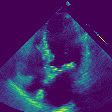

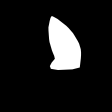

(112, 112, 1)


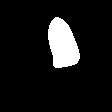

In [10]:
# Parse and display predicitons
def parse_preds(preds):
    """ Convert probabilities into object and background pixel values based on a threshold. """
    _preds = (preds > 0.5).astype(int)
    _preds = _preds * 255

    return _preds


def display_pred(i, preds):
    """ Display predictions. """
    preds = parse_preds(preds)
    mask = preds[i]
    print(mask.shape)
    mask = array_to_img(mask)
    display(mask)

example = 0
# Display input image
img = load_img(val_original_paths[example])
display(img)
# Display ground-truth target mask
target = PIL.ImageOps.autocontrast(load_img(val_mask_paths[example]))
display(target)

# Display mask predicted by our model
display_pred(example, val_preds)

In [11]:
def save_pred_input(i, path, name, rgb=False):
    image = load_img(path[i])
    image = img_to_array(image)
    if rgb is True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite('rgb_'+name, image)
    if rgb is False:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cv2.imwrite('gray_'+name, image)

save_pred_input(example, val_original_paths, 'valpred_input_image_10.png')
save_pred_input(example, val_original_paths, 'valpred_input_image_10.png', rgb=True)
save_pred_input(example, val_mask_paths, 'valpred_input_mask_10.png')

In [12]:
def save_pred_img(i, preds):
    preds = parse_preds(preds)
    mask = preds[i]
    #mask = cv2.imread(mask)
    cv2.imwrite('valpred_predmask_10.png', mask)

save_pred_img(example, val_preds)

In [13]:
def save_pred_overlay(i, preds):
    preds = parse_preds(preds)
    overlay = preds[i]

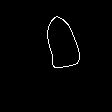

In [20]:
def detect_edges(i, preds):
    preds = parse_preds(preds)
    mask = preds[i]
    mask = np.array(mask).astype(np.uint8)
    mask_edges = cv2.Canny(mask, 100, 200)
    mask_edges = np.expand_dims(mask_edges, 2)
    mask_edges = array_to_img(mask_edges)
    display(mask_edges)

detect_edges(example, val_preds)


/home/samdev/anaconda3/envs/Cardio_Segmentation/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 113, 113, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 56, 56, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 56, 56, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

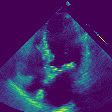

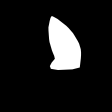

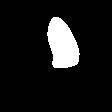

In [15]:
weights_edv_path = '../Notebook/weights_EDV.h5'
weights_esv_path = '../Notebook/weights_ESV.h5'

ed_model = build_unet()
ed_model.load_weights(filepath=weights_edv_path)
loaded_val_preds = ed_model.predict(val_gen_pred)

In [ ]:
example2 = 0
# Display input image
img = load_img(val_original_paths[example2])
display(img)
# Display ground-truth target mask
target = PIL.ImageOps.autocontrast(load_img(val_mask_paths[example2]))
display(target)

# Display mask predicted by our model
display_pred(example, loaded_val_preds)




In [19]:
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}



























































The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...